<a href="https://colab.research.google.com/github/careychou/exploration/blob/master/Probabilistic_NN_and_Keras_Functional_API_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import layers

tfd = tfp.distributions
tfb = tfp.bijectors

KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_1/Relu:0', description="created by layer 'dense_1'")
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


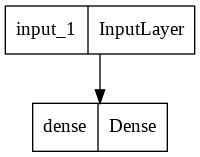

In [3]:
# simple keras functional API
inputs = tf.keras.Input(shape=(4,))
dense1 = tf.keras.layers.Dense(1, activation=tf.nn.relu)(inputs)
dense2 = tf.keras.layers.Dense(1, activation=tf.nn.relu)(dense1)
model = tf.keras.Model(inputs=inputs, outputs=dense1)
print(dense2)
x = np.array([[1., 1.]])
tf.keras.layers.Dense(1, activation=tf.nn.relu)(x)
#tf.keras.Model(inputs=model, outputs=dense2)
model.summary()
tf.keras.utils.plot_model(model)

In [4]:
# insert tf operation in functonal API
inputs = tf.keras.Input(shape=(2,))
weights = tf.Variable([[1., 1.], [1., 1.]], dtype='float32')
dense1 = tf.matmul(inputs, weights)
dense2 = tf.matmul(dense1, weights)
model1 = tf.keras.Model(inputs, dense1)
model2 = tf.keras.Model(dense1, dense2)
model1(np.array([[1., 1.]]))


<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[2., 2.]], dtype=float32)>

In [5]:
# how Functional API build the graph internally
inputs = tf.keras.Input(shape=(2,))
dense1 = tf.keras.layers.Dense(1, activation=tf.nn.relu)(inputs)
dense2 = tf.keras.layers.Dense(1, activation=tf.nn.relu)(dense1)
model1 = tf.keras.Model(inputs, dense2)
model2 = tf.keras.Model(dense1, dense2)
model1(np.array([[1., 1.]]))

# this is how Functional API call()
from tensorflow.python.keras.engine import functional
modelf = functional.Functional(inputs, dense2)
modelf._run_internal_graph(tf.constant(np.array([[1., 1.]])))

# this is how Functional API call for 1st layer
layer, index, _ = dense1._keras_history
layer.inbound_nodes[0].layer(tf.constant(np.array([[1., 1.]])))


<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.6664914]], dtype=float32)>

In [6]:
inputs = tf.keras.Input(shape=(4,))
dense1 = tf.keras.layers.Dense(1, activation=tf.nn.relu)(inputs)
dense2 = tf.keras.layers.Dense(1, activation=tf.nn.relu)(dense1)
model = tf.keras.Model(inputs=inputs, outputs=dense1)
print(dense2)
x = np.array([[1., 1.]])

KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_6/Relu:0', description="created by layer 'dense_6'")


In [16]:
# use DistributionLambda
x = tf.random.normal(shape=(2, 4))
dense1 = tf.keras.layers.Dense(1, activation=tf.nn.relu)(x)
normal1 = tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1))(dense1)

# TensorCoercible type
print(normal1)
tf.convert_to_tensor(normal1)

tfp.distributions._TensorCoercible("tensor_coercible", batch_shape=[2, 1], event_shape=[], dtype=float32)


<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[0.05081884],
       [0.85472673]], dtype=float32)>

In [20]:
# gradient with reparameterization in TFP
x = np.array([[1., 1.]])
dense1 = tf.keras.layers.Dense(1, activation=tf.nn.relu)
normal1 = tfp.layers.DistributionLambda(lambda t: tfd.InverseGaussian(loc=t, concentration=10))

with tf.GradientTape() as tape:
  y = dense1(x)
  print(y)
  y = normal1(y)
  print(y)
  y = y ** 1
  print(y)
  y = y ** 2
  print(y)

tape.gradient(y, dense1.trainable_variables)



tf.Tensor([[0.9761405]], shape=(1, 1), dtype=float32)
tfp.distributions._TensorCoercible("tensor_coercible", batch_shape=[1, 1], event_shape=[], dtype=float32)
tf.Tensor([[1.877592]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.5253515]], shape=(1, 1), dtype=float32)


[<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
 array([[9.308341],
        [9.308341]], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([9.308341], dtype=float32)>]

In [ ]:
x = tf.random.normal(shape=(2, 4))
dense1 = tf.keras.layers.Dense(1, activation=tf.nn.relu)
tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=dense1, scale=1))


with tf.GradientTape() as tape:
  y = dense1(x)
  y = y ** 2


tape.gradient(y, dense1.trainable_variables)

[<tf.Tensor: shape=(4, 1), dtype=float32, numpy=
 array([[ 1.8757645 ],
        [ 0.06258097],
        [-1.6873056 ],
        [-3.0941439 ]], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.5390193], dtype=float32)>]

In [23]:
# transform with TFB Softplus 
x = np.array([[1., 1.]])
dense1 = tf.keras.layers.Dense(1, activation=tf.nn.relu)
lambda1 = tf.keras.layers.Lambda(lambda t: tfb.Softplus()(t))
weibull1 = tfp.layers.DistributionLambda(lambda t: tfd.Weibull(concentration=t, scale=1.0))

y = dense1(x)
y = lambda1(y)
y = weibull1(y)
print('weibull:', tf.convert_to_tensor(y))

weibull: tf.Tensor([[0.6004501]], shape=(1, 1), dtype=float32)


In [25]:
# gradient with transform of tf softplus
x = np.array([[1., 1.]])
dense1 = tf.keras.layers.Dense(1, activation=tf.nn.relu)
lambda1 = tf.keras.layers.Lambda(lambda t: tf.math.softplus(t))
weibull1 = tfp.layers.DistributionLambda(lambda t: tfd.Weibull(concentration=t, scale=1.0))

with tf.GradientTape() as tape:
  y = dense1(x)
  print('dense:', y)
  y = lambda1(y)
  print('lambda:', y)
  y = weibull1(y)
  print('weibull:', y)
  y = y ** 1
  print(y)
  y = y ** 2
  print(y)

tape.gradient(y, dense1.trainable_variables)

dense: tf.Tensor([[1.2972121]], shape=(1, 1), dtype=float32)
lambda: tf.Tensor([[1.5388184]], shape=(1, 1), dtype=float32)
weibull: tfp.distributions._TensorCoercible("tensor_coercible", batch_shape=[1, 1], event_shape=[], dtype=float32)
tf.Tensor([[1.950014]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.8025546]], shape=(1, 1), dtype=float32)


[<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
 array([[-2.5921493],
        [-2.5921493]], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-2.5921493], dtype=float32)>]